In [1]:
import os
import sys
import fitsio
import pylab               as     pl
import numpy               as     np
import matplotlib.pyplot   as     plt
import astropy.io.fits     as     fits
import matplotlib          as     mpl
import astropy.units       as     u

from   astropy.table       import Table, join, unique
from   astropy.coordinates import SkyCoord
from   scipy.spatial       import Voronoi, voronoi_plot_2d
from astropy.cosmology import WMAP9 as cosmo

In [2]:
sys.path.append(os.environ['HOME'])
sys.path.append(os.environ['HOME'] + '/DESI/')

In [3]:
photoz = Table.read('/cosma/home/durham/dc-bigw1/data/EAZYPhotoZv02.fits')

In [4]:
sci = Table.read('/cosma/home/durham/dc-bigw1/data/gkvScienceCatv02.fits')
sci = sci[sci['SC'] >= 7] # r_KIDS < 19.65
sci = sci[sci['NQ'] >= 3]
sci.sort('uberID')
sci

uberID,RAcen,Deccen,RAmax,Decmax,RAGAIA,DecGAIA,sky_mean,skyRMS_mean,log10seeing,EBV,mag,R50,R90,R100,N100,axrat,ang,flux_FUVt,flux_FUVl,flux_err_FUVt,flux_NUVt,flux_NUVl,flux_err_NUVt,flux_ut,flux_ul,flux_err_ut,flux_gt,flux_gl,flux_err_gt,flux_rt,flux_rl,flux_err_rt,flux_it,flux_il,flux_err_it,flux_Zt,flux_Zl,flux_err_Zt,flux_Yt,flux_Yl,flux_err_Yt,flux_Jt,flux_Jl,flux_err_Jt,flux_Ht,flux_Hl,flux_err_Ht,flux_Kt,flux_Kl,flux_err_Kt,flux_W1t,flux_W1l,flux_err_W1t,flux_W2t,flux_W2l,flux_err_W2t,duplicate,mask,starmask,uberclass,CATAID,SC,Z,NQ
,deg,deg,deg,deg,deg,deg,Jy,Jy,log(arcsec),mag,mag,arcsec,arcsec,arcsec,,,deg,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,int16,int32,int16,float32,int16
128980003711188,129.579930278292,-1.02978043903405,129.579932683367,-1.02978364542057,129.579917127811,-1.0298019787539,-3.2522729e-13,3.9659894e-12,-0.25130096,0.039404288,17.2534,2.0644488,5.534397,12.665411,2359,0.5379462,14.949414,3.7622426e-06,1.8775262e-06,6.592376e-08,1.8948501e-06,4.639499e-07,1.783146e-07,3.1354277e-05,2.9739422e-05,2.3111963e-06,0.00017459311,0.00017035949,8.010887e-07,0.0004252589,0.00041564586,9.38886e-07,0.00063660165,0.0006154055,4.277399e-06,0.0008387682,0.00080726604,2.8500554e-06,0.0010912559,0.0010391885,4.318675e-06,0.0012729218,0.0012607822,6.7473425e-06,0.0016559247,0.0015765553,1.0185171e-05,0.0014912887,0.0014136028,1.1099676e-05,0.00076479634,0.0006932739,4.308207e-06,0.00041533215,0.00038133233,9.162291e-06,False,False,False,1,3600151,8,0.08185,4
128980004608892,129.579120957998,-1.24600373591109,129.57914237232902,-1.24597052992676,129.579126816773,-1.2459888632601,-6.235091e-13,4.45304e-12,-0.25130096,0.03663875,19.62488,1.4528091,2.7260127,3.5369992,246,0.71930766,24.843025,5.9163476e-06,1.5420331e-06,9.390429e-09,5.678131e-06,4.9415416e-06,1.072075e-07,1.3446274e-05,1.1603522e-05,7.3411456e-07,2.4912522e-05,2.1897316e-05,2.4025044e-07,5.027862e-05,4.645822e-05,3.0774183e-07,6.4226166e-05,5.7130877e-05,5.5112065e-07,7.798098e-05,7.505486e-05,6.6790915e-07,8.846863e-05,8.5702704e-05,1.5427186e-06,9.43052e-05,8.2926155e-05,2.7346246e-06,0.00011900299,0.00012463274,4.1954318e-06,0.0001302289,0.00011556382,4.5622137e-06,0.00010702925,8.509128e-05,8.0250607e-07,5.0995783e-05,5.126498e-05,6.123744e-07,False,False,False,1,3874273,7,0.30551,4
128980005210530,129.578549016984,-1.09171591981672,129.578536525687,-1.09173876283465,129.578520970131,-1.09175709616798,-1.9836392e-13,4.022541e-12,-0.25130096,0.03914747,18.26186,1.9691488,6.204499,9.950718,2356,0.87039423,70.918526,7.3471238e-06,-2.4907516e-08,8.244568e-08,1.1259933e-06,-1.0256644e-07,1.5518829e-07,6.6233483e-06,9.19258e-06,1.742145e-06,4.3395437e-05,4.187161e-05,7.553113e-07,0.00016725504,0.00015794583,1.5254071e-06,0.00025626548,0.00025793092,1.790889e-06,0.0003574356,0.0003447857,2.2677946e-06,0.0004627444,0.00042919506,5.314643e-06,0.0005765088,0.00058888376,7.3797073e-06,0.00087760214,0.0007020546,2.6406551e-05,0.0009705686,0.00092936575,1.230545e-05,0.00048209692,0.0004506983,2.3163009e-06,0.00032877963,0.00026765966,8.127045e-06,False,False,False,1,3600249,8,0.28994,4
128980005309861,129.578474121309,-1.15473342154572,129.57845900453998,-1.1547303401663502,129.578443448984,-1.15474867349968,-1.9509249e-13,4.1204718e-12,-0.25130096,0.03815698,19.45848,1.9135718,3.8647137,5.6677957,511,0.5818916,19.881395,1.15e-05,5.6613226e-06,8.696644e-08,4.482213e-06,3.6730312e-06,6.714967e-08,1.1671629e-05,9.862621

In [5]:
sci = join(sci, photoz, join_type='left', keys='uberID')

In [6]:
#box of science catalogue

isin  = (sci['Deccen'] > -2.0)
isin &= (sci['Deccen'] <  2.0)
isin &= (sci['RAcen']  > 130.)
isin &= (sci['RAcen']  < 134.)

sci   = sci[isin]
sci

uberID,RAcen,Deccen,RAmax,Decmax,RAGAIA,DecGAIA,sky_mean,skyRMS_mean,log10seeing,EBV,mag,R50,R90,R100,N100,axrat,ang,flux_FUVt,flux_FUVl,flux_err_FUVt,flux_NUVt,flux_NUVl,flux_err_NUVt,flux_ut,flux_ul,flux_err_ut,flux_gt,flux_gl,flux_err_gt,flux_rt,flux_rl,flux_err_rt,flux_it,flux_il,flux_err_it,flux_Zt,flux_Zl,flux_err_Zt,flux_Yt,flux_Yl,flux_err_Yt,flux_Jt,flux_Jl,flux_err_Jt,flux_Ht,flux_Hl,flux_err_Ht,flux_Kt,flux_Kl,flux_err_Kt,flux_W1t,flux_W1l,flux_err_W1t,flux_W2t,flux_W2l,flux_err_W2t,duplicate,mask,starmask,uberclass,CATAID_1,SC,Z,NQ,CATAID_2,all_primary,science_primary,star_primary,nfilt,z_peak,peak_prob,chi2_fit,fitflux_u,fitflux_g,fitflux_r,fitflux_i,fitflux_Z,fitflux_Y,fitflux_J,fitflux_H,fitflux_K,z_1,chi2_1,temp_1,z_m1,z_p,chi2_p,temp_p,z_m2,z_mc,l68,u68,l95,u95,l99,u99,odds,Qz
,deg,deg,deg,deg,deg,deg,Jy,Jy,log(arcsec),mag,mag,arcsec,arcsec,arcsec,,,deg,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,int16,int32,int16,float32,int16,int32,bool,bool,bool,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
129980010706612,130.573457870055,-1.46073275858253,130.573453744232,-1.4606593753345,130.573438188676,-1.46067770866783,-1.3957646e-12,4.091705e-12,-0.21480854,0.03678473,19.141712,2.2412927,4.5785937,7.6182075,771,0.4859575,171.5484,1.8775914e-05,1.7034567e-05,8.332097e-08,1.5110067e-05,1.4594849e-05,1.530182e-07,2.1347962e-05,2.040285e-05,1.000748e-06,5.935096e-05,5.6521763e-05,4.1723882e-07,8.192321e-05,7.8915e-05,5.2436167e-07,0.000104148516,0.00010384664,1.3761182e-06,0.000111932495,0.00010984605,1.2393679e-06,0.00012901853,0.00011563948,2.4512872e-06,0.000115055176,0.00012925484,4.3080013e-06,0.00010868858,0.00017188267,7.783908e-06,0.00013614589,0.00016986736,8.295606e-06,6.992865e-05,5.9425834e-05,8.8233594e-07,1.4143345e-05,2.7285865e-05,9.589933e-07,False,False,False,1,3578329,8,0.08218,4,3578329,True,True,False,9,0.06568623,1.0,18.715342,2.232221e-05,5.9611848e-05,7.863037e-05,9.7044016e-05,0.00011029359,0.00012572687,0.00012497681,0.00013960116,0.00013087437,0.053166185,18.02968,24,0.06,0.053166185,18.02968,24,0.065708205,0.0567,0.044,0.089,0.033,0.109,0.022,0.129,1.0,0.335094
129980012101904,130.572335913085,-1.904034100009,130.572251053251,-1.90396757029708,130.572235497696,-1.90398590363042,-4.6790545e-13,4.129585e-12,-0.21480854,0.03856791,19.36115,1.4547489,3.8414307,6.449546,942,0.82840395,36.651016,4.2805127e-06,4.3612713e-06,6.7260395e-08,3.3529006e-06,3.5436117e-06,1.1579065e-07,5.77295e-06,-1.0313689e-06,1.1620041e-06,2.227623e-05,1.9796178e-05,4.2804686e-07,6.4516986e-05,6.183063e-05,7.293705e-07,9.378448e-05,8.217368e-05,1.5904293e-06,0.00012819204,0.00011929531,1.7115235e-06,0.00014967428,0.00014789018,2.8265188e-06,0.00018411243,0.00021395308,5.7284633e-06,0.0002334647,0.00021823483,1.1220206e-05,0.0003024155,0.00027727292,9.65601e-06,0.00013930238,0.0001225499,1.4766243e-06,6.814529e-05,7.084898e-05,1.1557621e-06,False,False,False,1,3554696,8,0.2617,4,3554696,True,True,False,9,0.2914267,1.0,4.460593,7.571509e-06,2.2644923e-05,6.367421e-05,9.240583e-05,0.00012671345,0.00015159819,0.00019350823,0.00022957944,0.0002907268,0.3059642,3.9722,15,0.293,0.3059642,3.9722,15,0.2914754,0.3033,0.238,0.33,0.177,0.368,0.13,0.402,1.0,0.2

In [7]:
c                              = SkyCoord(ra=sci['RAcen'], dec=sci['Deccen'])

In [8]:
uids, cnts                     = np.unique(sci['uberID'].data, return_counts=True)

In [9]:
def cartesian(ras, decs, zs, rotate=False):
    phi        = np.radians(ras)
    theta      = np.pi/2. - np.radians(decs)

    mean_phi   = np.median(phi)
    mean_theta = np.median(theta)
    
    chis       = cosmo.comoving_distance(zs).value # [Mpc/h].

    zs         = chis * np.cos(theta)
    ys         = chis * np.sin(theta) * np.sin(phi)
    xs         = chis * np.sin(theta) * np.cos(phi)

    pos        = np.c_[xs, ys, zs]

    if rotate:
        pos    = rotate(ras, decs, pos)

    return  pos

In [10]:
nneighbour = 25000

neighbours = []

for i, uid in enumerate(uids):
    # Centering point
    catalog                    = SkyCoord(ra=[sci['RAcen'][i] * u.deg], dec=[sci['Deccen'][i] * u.deg])

    idxc, idxcatalog, d2d, d3d = catalog.search_around_sky(c, 10. * u.arcmin)

    matches                    = c[idxc][d2d > 2. * u.arcsec]
    ids                        = sci['uberID'][idxc][d2d > 2. * u.arcsec]
    zs                         = sci['Z'][idxc][d2d > 2. * u.arcsec]

    d2d                        = d2d[d2d > 2. * u.arcsec]
    
    idxs                       = np.argsort(d2d)
    idx                        = idxs[0]
    
    neighbor                   = matches[idx]
    uberID                     = ids[idx]
    separation                 = d2d[idx].arcsec
    zz                         = zs[idx]
    
    zbias                      = np.abs(sci['Z'][i] - zz)
    
    # print(sci['uberID'][i], uberID, separation)
    target_pos = cartesian(sci['RAcen'][i],sci['Deccen'][i],sci['Z'][i])
    neighbours_pos = cartesian(neighbor.ra.degree,neighbor.dec.degree,zz)
    
    distSq = (np.square(neighbours_pos - target_pos)).sum(axis=1)
    
    comov_dis = float(np.sqrt(distSq))
        
    neighbours.append([sci['uberID'][i], sci['Z'][i], uberID, zz, separation, zbias,comov_dis])
    
    if i > nneighbour:
        break
        
    else:
        if (i % 100) == 0:
            print(100. * i / len(uids))
            
dt         = np.dtype([('uberID', np.int), ('Separation', np.float64)])
    
neighbours = np.array(neighbours)
neighbours = Table(neighbours, names=['uberID', 'Z', 'match_uberID', 'match_Z', 'separation', 'zbias','comoving_distance'])

0.0
0.7841907151819323
1.5683814303638646
2.3525721455457966
3.136762860727729
3.920953575909661
4.705144291091593
5.489335006273525
6.273525721455458
7.05771643663739
7.841907151819322
8.626097867001254
9.410288582183187
10.194479297365119
10.97867001254705
11.762860727728985
12.547051442910917
13.331242158092849
14.11543287327478
14.899623588456713
15.683814303638645
16.468005018820577
17.25219573400251
18.03638644918444
18.820577164366373
19.604767879548305
20.388958594730237
21.17314930991217
21.9573400250941
22.741530740276033
23.52572145545797
24.3099121706399
25.094102885821833
25.878293601003765
26.662484316185697
27.44667503136763
28.23086574654956
29.015056461731493
29.799247176913426
30.583437892095358
31.36762860727729
32.151819322459225
32.936010037641154
33.72020075282309
34.50439146800502
35.28858218318695
36.07277289836888
36.85696361355082
37.641154328732746
38.42534504391468
39.20953575909661
39.993726474278546
40.777917189460474
41.56210790464241
42.34629861982434
43

Text(0.5, 0, 'Comoving distance to nearest neighbour')

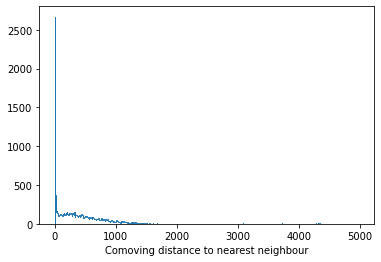

In [13]:
_ = pl.hist(neighbours['comoving_distance'], bins=np.arange(0.0, 5.e3, 1.e1), histtype='step')

pl.xlabel('Comoving distance to nearest neighbour')

In [14]:
points    = [[xx['RAcen'], xx['Deccen']] for xx in sci]

(-2.0, 2.0)

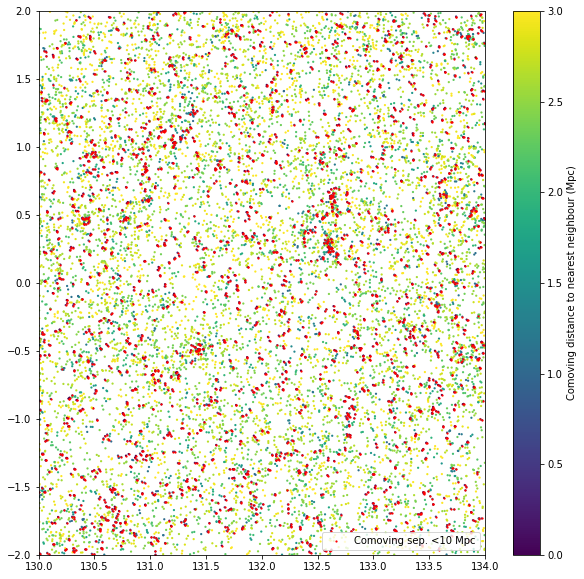

In [31]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

sc      = ax.scatter(np.array(points)[:,0],\
                     np.array(points)[:,1],\
                     c=np.log10(neighbours['comoving_distance']),\
                     marker='.',\
                     lw=0.0,\
                     s=20,\
                     vmin=0.0,\
                     vmax=3)

pl.colorbar(sc, label='Comoving distance to nearest neighbour (Mpc)')

ax.scatter(np.array(points)[:,0][neighbours['comoving_distance']<10],\
                     np.array(points)[:,1][neighbours['comoving_distance']<10],\
                     c='red',\
                     marker='.',\
                     lw=0.0,\
                     s=20,\
                     label='Comoving sep. <10 Mpc')
pl.legend()
pl.xlim(130., 134.)
pl.ylim(-2.,    2.)

In [ ]:
#redshift shells 
#cut at z = 0.3

In [16]:
def PolyArea(x,y):
    return  0.5 * np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [17]:
vor       = Voronoi(points)

In [18]:
inv_areas = -99. * np.ones(len(points))

for i, region in enumerate(vor.regions):
    xx    = vor.vertices[region][:,0]
    yy    = vor.vertices[region][:,1]
    
    AA    = PolyArea(xx,yy)
    
    isin  = (vor.point_region == i)
    
    inv_areas[isin] = 1. / AA

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [19]:
neighbours['density'] = inv_areas

Text(0.5, 0, 'Inv. Voronoi area')

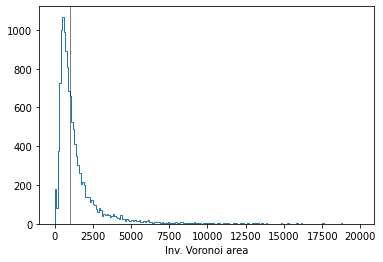

In [20]:
_ = pl.hist(inv_areas, bins=np.arange(0.0, 2.e4, 1.e2), histtype='step')

pl.axvline(1000, c='k', lw=0.5)
pl.xlabel('Inv. Voronoi area')

Text(0, 0.5, 'Number of points within 10 Mpc of neighbour')

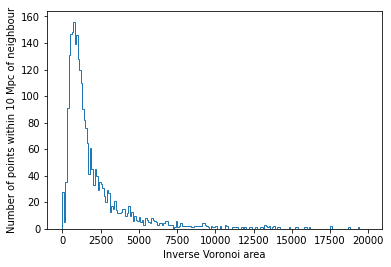

In [26]:
_ = pl.hist(inv_areas[neighbours['comoving_distance']<10], bins=np.arange(0.0, 2.e4, 1.e2), histtype='step')


pl.xlabel('Inverse Voronoi area')
pl.ylabel('Number of points within 10 Mpc of neighbour')